In [ ]:
!pip install transformers

In [ ]:
import time
import numpy as np
import pandas as pd

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertPreTrainedModel, BertModel
from transformers import get_linear_schedule_with_warmup


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print(f'Found GPU at: {device_name}')

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

using the CPU


In [ ]:
MAX_LEN = 128 # max sequences length
batch_size = 32

In [ ]:
german = pd.read_csv("/content/drive/MyDrive/German.csv")
german['new_label'] = ''

# Use conditions to assign labels
german.loc[(german['Overall_Rating'] >= 0.1) & (german['Overall_Rating'] <= 0.3), 'new_label'] = 'true'
german.loc[(german['Overall_Rating'] >= 0.4) & (german['Overall_Rating'] <= 0.5), 'new_label'] = 'others'

german.loc[(german['Overall_Rating'] >= 0.6) & (german['Overall_Rating'] <= 0.7), 'new_label'] = 'partially false'
german.loc[(german['Overall_Rating'] >= 0.8) & (german['Overall_Rating'] <= 1.0), 'new_label'] = 'false'

columns_to_drop = ['False_Statement_1_Location', 'False_Statement_1_Index', 'False_Statement_2_Location',
                   'False_Statement_2_Index', 'False_Statement_3_Location',
                   'False_Statement_3_Index', 'Ratio_of_Fake_Statements' ,'Overall_Rating']  # Replace with the actual column names you want to drop

# Use the drop method to remove the specified columns
german = german.drop(columns=columns_to_drop)

In [ ]:
german.head()

,Date,URL,titel,text,new_label
0,2017-08-30,https://schluesselkindblog.com/2017/08/30/proz...,SKB NEWS – ein mainstreamunabhängiger Nachrich...,UN-Migrationspläne für Bevölkerungsvermischung...,partially false
1,2017-12-18,http://blauerbote.com/2017/12/18/bild-journali...,BILD-Journalist Julian Röpcke und seine Nazifr...,Es ist schon ein (Haken-) Kreuz mit der Bildze...,false
2,2017-06-02,http://blauerbote.com/2017/06/02/angela-merkel...,Angela Merkel läßt Rock am Ring abbrechen – Bl...,Auch heute noch für Aufsehen sorgte der Widers...,partially false
3,2017-09-25,http://smopo.ch/deutschlands-neonazis-waehlen-...,This domain has been registered for a customer...,NaN,false
4,2018-02-17,http://www.truth24.net/gruppenvergewaltigung-s...,Gruppenvergewaltigung: Sex Jihadisten vergewal...,Bad Soden / Hofheim. Beim Herumvagabundieren ü...,others


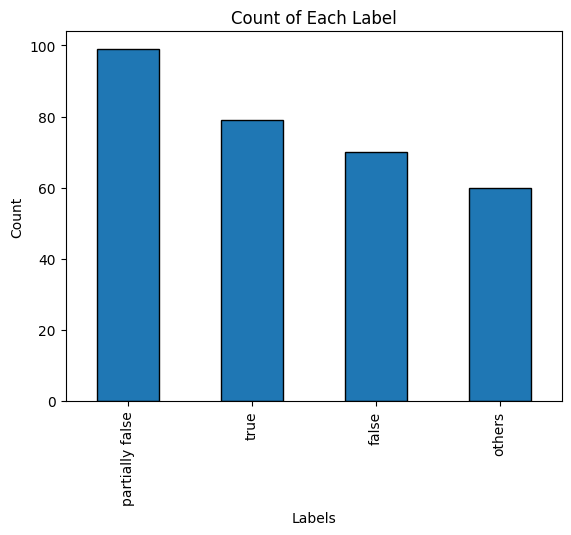

In [ ]:
label_counts = german['new_label'].value_counts()

# Plot bar chart
label_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Each Label')
plt.show()

In [ ]:
# kaggle = pd.read_csv("/content/drive/MyDrive/news.csv")
# columns_to_drop = ['id', 'Kategorie', 'Quelle', 'Art']  # Replace with the actual column names you want to drop

# # Use the drop method to remove the specified columns
# kaggle = kaggle.drop(columns=columns_to_drop)
# new_col_names = {'url':'URL','Titel':'titel','Body':'text','url':'URL','Datum':'Date'}
# kaggle = kaggle.rename(columns=new_col_names)

In [ ]:
# kaggle.head()

,URL,titel,text,Date,Fake
0,http://www.der-postillon.com/2018/01/grokoleak...,Exklusiv! Das geheime WhatsApp-Chat-Protokoll ...,Die Sondierungsgespräche zwischen Union und SP...,18-01-2018 0:00,1
1,http://www.der-postillon.com/2018/01/trump-san...,"Trump droht, jeden zu verspeisen, der an seine...",Nun ist es auch medizinisch offiziell bestätig...,17-01-2018 0:00,1
2,http://www.der-postillon.com/2018/01/fdp-sondi...,"Soli runter, keine Steuererhöhungen, kein Klim...","Es waren zähe Verhandlungen, doch die Freien D...",12-01-2018 0:00,1
3,http://www.der-postillon.com/2018/01/joachim-s...,Hat sie eine Affäre? Joachim Sauer glaubt Ange...,Wo treibt sie sich immer bis spät in die Nacht...,09-01-2018 0:00,1
4,http://www.der-postillon.com/2018/01/halb-so-s...,"""Er hat ja nur HALBneger gesagt"": So begründet...",Der Parteivorstand drückt nochmal ein Auge zu:...,08-01-2018 0:00,1


In [ ]:
# frames = [kaggle,german]
# result = pd.concat(frames)
# result.head()

,URL,titel,text,Date,Fake
0,http://www.der-postillon.com/2018/01/grokoleak...,Exklusiv! Das geheime WhatsApp-Chat-Protokoll ...,Die Sondierungsgespräche zwischen Union und SP...,18-01-2018 0:00,1
1,http://www.der-postillon.com/2018/01/trump-san...,"Trump droht, jeden zu verspeisen, der an seine...",Nun ist es auch medizinisch offiziell bestätig...,17-01-2018 0:00,1
2,http://www.der-postillon.com/2018/01/fdp-sondi...,"Soli runter, keine Steuererhöhungen, kein Klim...","Es waren zähe Verhandlungen, doch die Freien D...",12-01-2018 0:00,1
3,http://www.der-postillon.com/2018/01/joachim-s...,Hat sie eine Affäre? Joachim Sauer glaubt Ange...,Wo treibt sie sich immer bis spät in die Nacht...,09-01-2018 0:00,1
4,http://www.der-postillon.com/2018/01/halb-so-s...,"""Er hat ja nur HALBneger gesagt"": So begründet...",Der Parteivorstand drückt nochmal ein Auge zu:...,08-01-2018 0:00,1


In [ ]:
german['sent'] = german['titel'] + " " + german["text"]

In [ ]:
german.isnull().sum()

Date         19
URL           0
titel         1
text         52
new_label     0
sent         52
dtype: int64

In [ ]:
german = german.dropna()

In [ ]:
from transformers import BertTokenizer
import numpy as np
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 128  # Replace with your desired max length

def preprocessing(df):
    sentences = german.sent.values
    labels = german.new_label.values  # Assuming labels are already 0 and 1

    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

    encoded_sentences = []
    for sent in sentences:
        encoded_sent = tokenizer.encode(
                            sent,
                            add_special_tokens=True,
                            truncation=True,
                            max_length=MAX_LEN
                    )

        encoded_sentences.append(encoded_sent)
    encoded_sentences = pad_sequences(encoded_sentences, maxlen=MAX_LEN, dtype="long",
                            value=0, truncating="post", padding="post")
    return encoded_sentences, labels

def attention_masks(encoded_sentences):
    # Attention masks, 0 for padding, 1 for actual token
    attention_masks = []
    for sent in encoded_sentences:
        att_mask = [int(token_id > 0) for token_id in sent]
        attention_masks.append(att_mask)
    return attention_masks


In [ ]:
label_mapping = {'true': 0, 'false': 1, 'partially false': 2, 'others': 3}
german['new_label'] = german['new_label'].map(label_mapping)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(german, test_size=0.2, random_state=42)

In [ ]:
train_df = train_df[['sent', 'new_label']]
val_df = val_df[['sent', 'new_label']]


In [ ]:
train_encoded_sentences, train_labels = preprocessing(train_df)
train_attention_masks = attention_masks(train_encoded_sentences)

test_encoded_sentences, test_labels = preprocessing(val_df)
test_attention_masks = attention_masks(test_encoded_sentences)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
train_inputs = torch.tensor(train_encoded_sentences)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_attention_masks)

validation_inputs = torch.tensor(test_encoded_sentences)
validation_labels = torch.tensor(test_labels)
validation_masks = torch.tensor(test_attention_masks)

In [ ]:
# data loader for training
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# data loader for validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False,
)


optimizer = AdamW(model.parameters(),
                  lr = 3e-5,
                  eps = 1e-8,
                  weight_decay = 0.01
                )

epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # 10% * datasetSize/batchSize
                                            num_training_steps = total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def compute_accuracy(preds, labels):
    p = np.argmax(preds, axis=1).flatten()
    l = labels.flatten()
    return np.sum(p==l)/len(l)

def run_train(epochs):
    losses = []
    for e in range(epochs):
        print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
        start_train_time = time.time()
        total_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):

            if step%10 == 0:
                elapsed = time.time()-start_train_time
                print(f'{step}/{len(train_dataloader)} --> Time elapsed {elapsed}')

            # input_data, input_masks, input_labels = batch
            input_data = batch[0].to(device)
            input_masks = batch[1].to(device)
            input_labels = batch[2].to(device)

            model.zero_grad()

            # forward propagation
            out = model(input_data,
                        token_type_ids = None,
                        attention_mask = input_masks,
                        labels = input_labels)

            loss = out[0]
            total_loss = total_loss + loss.item()

            # backward propagation
            loss.backward()

            torch.nn.utils.clip_grad_norm(model.parameters(), 1)

            optimizer.step()

        epoch_loss = total_loss/len(train_dataloader)
        losses.append(epoch_loss)
        print(f"Training took {time.time()-start_train_time}")

        # Validation
        start_validation_time = time.time()
        model.eval()
        eval_loss, eval_acc = 0,0
        for step, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(device) for t in batch)
            eval_data, eval_masks, eval_labels = batch
            with torch.no_grad():
                out = model(eval_data,
                            token_type_ids = None,
                            attention_mask=eval_masks)
            logits = out[0]

            #  Uncomment for GPU execution
            logits = logits.detach().cpu().numpy()
            eval_labels = eval_labels.to('cpu').numpy()
            batch_acc = compute_accuracy(logits, eval_labels)

            # Uncomment for CPU execution
            # batch_acc = compute_accuracy(logits.numpy(), eval_labels.numpy())

            eval_acc += batch_acc
        print(f"Accuracy: {eval_acc/(step+1)}, Time elapsed: {time.time()-start_validation_time}")
    return losses


In [ ]:
losses = run_train(epochs)

======== Epoch 1 / 3 ========
0/8 --> Time elapsed 0.042089223861694336


<ipython-input-41-0a167088369f>:38: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1)


Training took 356.8485200405121
Accuracy: 0.34348958333333335, Time elapsed: 105.22823977470398
======== Epoch 2 / 3 ========
0/8 --> Time elapsed 0.005287647247314453
Training took 336.22425723075867
Accuracy: 0.44947916666666665, Time elapsed: 105.88402271270752
======== Epoch 3 / 3 ========
0/8 --> Time elapsed 0.0045318603515625
Training took 335.19520711898804
Accuracy: 0.5721354166666667, Time elapsed: 108.41607880592346


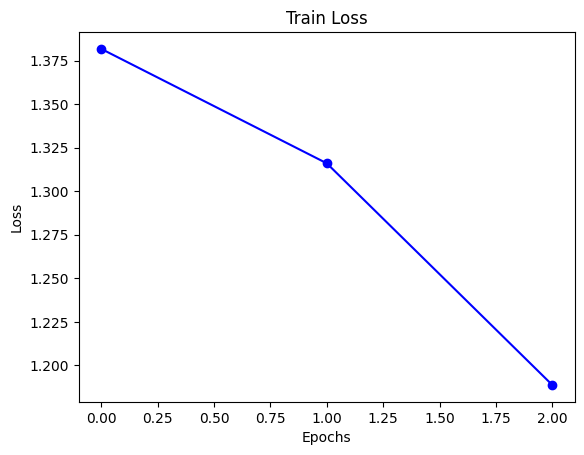

In [ ]:
# plot losses
import matplotlib.pyplot as plt


import seaborn as sns

plt.plot(losses, 'b-o')
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
import os

output_dir = './model_save'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

In [ ]:
from sklearn.metrics import classification_report

def run_test(df_test):
    test_encoded_sentences, test_labels = preprocessing(df_test)
    test_attention_masks = attention_masks(test_encoded_sentences)

    test_inputs = torch.tensor(test_encoded_sentences)
    test_labels = torch.tensor(test_labels)
    test_masks = torch.tensor(test_attention_masks)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    model.eval()
    eval_loss, eval_acc = 0, 0
    all_preds = []
    all_labels = []

    for step, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        eval_data, eval_masks, eval_labels = batch
        with torch.no_grad():
            out = model(eval_data,
                        token_type_ids=None,
                        attention_mask=eval_masks)
        logits = out[0]
        logits = logits.detach().cpu().numpy()
        eval_labels = eval_labels.to('cpu').numpy()
        batch_acc = compute_accuracy(logits, eval_labels)
        eval_acc += batch_acc

        # Store predictions and true labels for later use
        all_preds.extend(np.argmax(logits, axis=1))
        all_labels.extend(eval_labels)

    accuracy = eval_acc / (step + 1)
    print(f"Accuracy: {accuracy}")

    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))


In [ ]:
df_test = pd.read_csv("/content/test.csv")
df_test['sent'] = df_test['text'] + " " + df_test["title"]
df_test.head()

,ID,text,title,our rating,sent
0,1.23952E+38,Die Zahl der positiven Corona-Tests wird in kl...,Statistik: Wie man Corona-Zahlen ins Riesenhaf...,Partially False,Die Zahl der positiven Corona-Tests wird in kl...
1,3.07041E+38,Der große britische Kriegspremier Winston Chur...,"Corona: Sag mir, wo die Grippekranken sind, wo...",Partially False,Der große britische Kriegspremier Winston Chur...
2,8.66681E+37,"Es ist der große Plan B, über den vor der Wahl...",Geheime Planspiele von „Grünen“ und SPD-Linken...,FALSE,"Es ist der große Plan B, über den vor der Wahl..."
3,1.25255E+38,"Andere Länder, andere Sitten! Weil die Impfquo...",Ungeimpfte dürfen nicht mehr in den Supermarkt...,FALSE,"Andere Länder, andere Sitten! Weil die Impfquo..."
4,1.63336E+37,"Ungenügende Studien, unüberschaubare Nebenwirk...",Pathologen enthüllen Obduktionsergebnisse von ...,Other,"Ungenügende Studien, unüberschaubare Nebenwirk..."


In [ ]:
unique_ratings = df_test['our rating'].unique()
print("Unique Ratings:", unique_ratings)

Unique Ratings: ['Partially False' 'FALSE' 'Other' 'TRUE']


In [ ]:
label_mapping = {'TRUE': 0, 'FALSE': 1, 'Partially False': 2, 'Other': 3}
df_test['new_label'] = df_test['our rating'].map(label_mapping)

In [ ]:
df_test = df_test[['sent', 'new_label']]

In [ ]:
run_test(df_test)

Accuracy: 0.5721354166666667

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.78      0.62        63
           1       0.58      0.67      0.62        49
           2       0.60      0.65      0.62        80
           3       0.00      0.00      0.00        47

    accuracy                           0.56       239
   macro avg       0.42      0.53      0.47       239
weighted avg       0.45      0.56      0.50       239



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
